# Install required packages


In [36]:
#!pip install torch torchvision torchaudio
#!pip install transformers pillow opencv-python matplotlib
#!pip install mtcnn
#!pip install protobuf==3.20.3

 # Import Libraries

In [37]:
import cv2
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from mtcnn import MTCNN

# Upload the Image

In [38]:
uploaded = files.upload()

if not uploaded:
    raise ValueError("No file uploaded. Please try again.")

image_path = list(uploaded.keys())[0]
print(f"Uploaded: {image_path}")

Saving Screenshot 2025-09-01 at 11.47.42 PM.png to Screenshot 2025-09-01 at 11.47.42 PM (1).png
Uploaded: Screenshot 2025-09-01 at 11.47.42 PM (1).png


# Load Image and Initialize Model

In [39]:
# Load the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Failed to read the image. Please check the file format (e.g., JPG/PNG).")

# Initialize the face mask detection model
model_name = "prithivMLmods/Face-Mask-Detection"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

# Label mapping
id2label = {0: "Mask", 1: "No Mask"}

detector = MTCNN()

# Detect Faces Using MTCNN

In [40]:
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces = detector.detect_faces(rgb_image)

print(f"Detected {len(faces)} faces in the image.")

image_with_boxes = image.copy()
results = []

Detected 8 faces in the image.


# Process Each Face and Predict Mask Status

In [41]:
for i, face in enumerate(faces):
    x, y, w, h = face['box']

    # Ensure valid bounding box
    if w <= 0 or h <= 0:
        continue

    # Extract face region
    face_img = image[y:y+h, x:x+w]

    # Convert to PIL Image (RGB)
    pil_face = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))

    # Resize to match model input size
    pil_face = pil_face.resize((224, 224))

    # Preprocess for the model
    inputs = processor(images=pil_face, return_tensors="pt")

    # Predict without gradient computation
    with torch.no_grad():
        outputs = model(**inputs)

    # Compute probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].numpy()
    pred_label_id = probs.argmax()
    label = id2label[pred_label_id]
    confidence = probs[pred_label_id]

    # Store result
    results.append((label, confidence, (x, y, w, h)))

    # Set box color: green for mask, red for no mask
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # Draw bounding box
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)

    # Add label text
    text = f"{label} ({confidence * 100:.1f}%)"
    cv2.putText(image_with_boxes, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Display Results

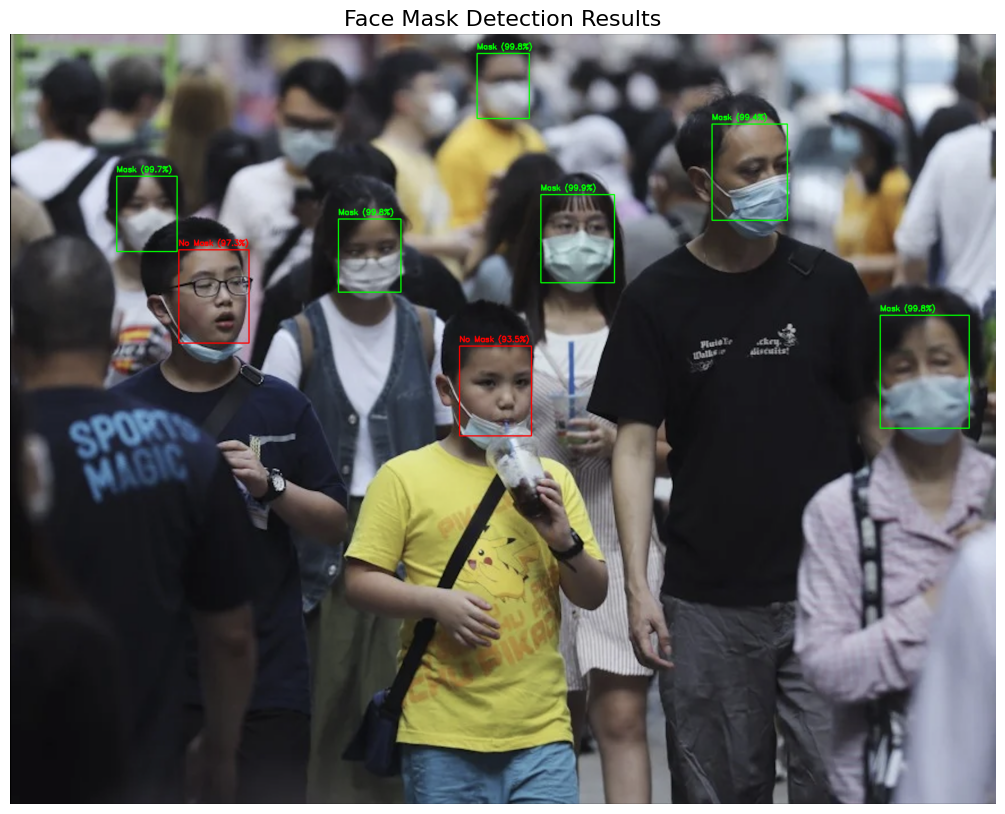

In [42]:
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Face Mask Detection Results", fontsize=16)
plt.show()